## Import libraries

In [1]:
import quail
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import scipy
import matplotlib.patches as patches
import matplotlib as mpl
%matplotlib inline

## Settings and parameters

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
datadir = '../../../data/processed/'
palette = 'bone'

def _z2r(z):
    """
    Function that calculates the inverse Fisher z-transformation

    Parameters
    ----------
    z : int or ndarray
        Fishers z transformed correlation value

    Returns
    ----------
    result : int or ndarray
        Correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)


def _r2z(r):
    """
    Function that calculates the Fisher z-transformation

    Parameters
    ----------
    r : int or ndarray
        Correlation value

    Returns
    ----------
    result : int or ndarray
        Fishers z transformed correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))

## Load data

In [3]:
video_events = np.load(datadir+'video_events.npy', allow_pickle=True)
recall_events = np.load(datadir+'recall_events.npy', allow_pickle=True)

ks = [i.shape[0] for i in recall_events]
hand_rec = np.array([27, 24, 32, 33, 32, 39, 30, 39, 28, 40, 34, 38, 47, 38, 27, 37, 39])

## Define some functions

In [4]:
def precision_func(video, recall):
    return np.max(1 - cdist(video, recall, 'correlation'), 0).mean()

def distinctiveness_func(video, recall):
    corrmat = 1 - cdist(video, recall, 'correlation')
    return 1 - np.mean([np.sort(r_ev)[:-1].mean() for r_ev in corrmat.T])

def corr_pearsonr(r_vals, metric2):
    return pearsonr(_r2z(np.array(r_vals)), metric2)

def fmt_stat(stat):
    if stat[1] < .001:
        return "r = " + str(round(stat[0], 2)) + ", p < .001"
    else:
        return "r = " + str(round(stat[0], 2)) + ", p = " + str(round(stat[1], 3))

/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


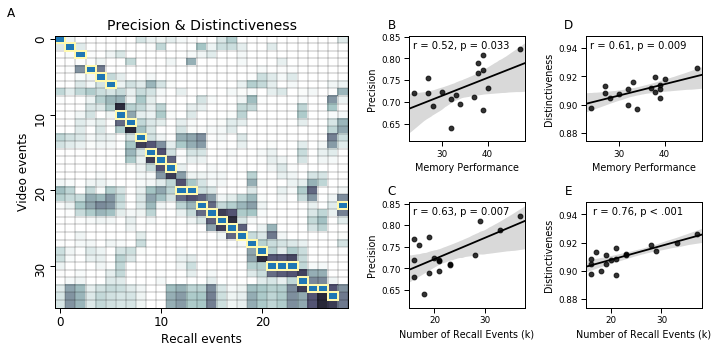

In [5]:
# general settings and 
sns.set_context('paper')
cmap = plt.cm.bone_r
mpl.rcParams['pdf.fonttype'] = 42


fig = plt.figure()
fig.set_size_inches(10, 5)
gs = fig.add_gridspec(2, 4)

a = fig.add_subplot(gs[0:, :-2])
b = fig.add_subplot(gs[0, 2])
c = fig.add_subplot(gs[1, 2])
d = fig.add_subplot(gs[0, 3])
e = fig.add_subplot(gs[1, 3])

# format the data
precision = [precision_func(video_events, r) for r in recall_events]
distinctiveness = [distinctiveness_func(video_events, r) for r in recall_events]

df = pd.DataFrame(np.array([hand_rec, ks, precision, distinctiveness]).T, 
                  columns=['Memory Performance', 'Number of Recall Events (k)', 
                           'Precision', 'Distinctiveness'])

# precision schematic
data = 1 - cdist(video_events, recall_events[16], 'correlation')
g1 = sns.heatmap(data, 
                 cmap='bone_r', xticklabels=10, yticklabels=10, 
                 vmin=0, vmax=1, ax = a, cbar = False)
g1.set_title('Precision & Distinctiveness', fontsize=14)
g1.set_ylabel('Video events', fontsize=12)
g1.set_xlabel('Recall events', fontsize=12)
g1.tick_params('both', labelsize=12)
for _, spine in g1.spines.items():
    spine.set_visible(True)
g1.hlines(list(range(video_events.shape[0])), *g1.get_xlim(), linewidth=.25)
g1.vlines(list(range(recall_events[16].shape[1])), *g1.get_ylim(), linewidth=.25)
bounds = np.argmax(data, axis=0)
for i in range(len(bounds)):
    rect = patches.Rectangle((i,bounds[i]), 1, 1, linewidth=2, edgecolor='#FFF9AE', facecolor=None, zorder=2, alpha = 1)
    g1.add_patch(rect)
    
# correlation plots
sns.regplot(df['Memory Performance'], df['Precision'], ax = b, color = 'black')
sns.regplot(df['Number of Recall Events (k)'], df['Precision'], ax = c, color = 'black')
sns.regplot(df['Memory Performance'], df['Distinctiveness'], ax = d, color = 'black')
sns.regplot(df['Number of Recall Events (k)'], df['Distinctiveness'], ax = e, color = 'black')

# add labels
label=['A', 'B', 'C', 'D', 'E']
for p, l in zip([a, b, c, d, e], label):
    p.text(-.15,1.07,l,
        horizontalalignment='center',
        transform=p.transAxes,
          fontsize=12)
    
# add stats
cols = [('Precision', 'Memory Performance'), 
        ('Precision', 'Number of Recall Events (k)'),
       ('Distinctiveness', 'Memory Performance'),
       ('Distinctiveness', 'Number of Recall Events (k)')]
for p, c in zip([b, c, d, e], cols):
    stat = scipy.stats.pearsonr(df[c[0]], df[c[1]])
    p.text(.45,.88,fmt_stat(stat),
        horizontalalignment='center',
        transform=p.transAxes,
          fontsize=10)

plt.subplots_adjust(wspace=.25, hspace=.25)
plt.tight_layout()

# plt.savefig('../../../paper/figs/precision_distinctiveness.pdf')